<a href="https://colab.research.google.com/github/AmyBeisel/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/214_assignmentAMY_BEISEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [x] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [x] Begin with baselines for classification.
- [x] Use scikit-learn for logistic regression.
- [x] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [x] Make exploratory visualizations.
- [x] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [x] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [7]:
print(df.shape)
df.head()

(421, 59)


,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [8]:
#I always like to check missing data
#I need to learn how to change all those nans, x's and X's into 0 and 1's. In most columns. 
df.isnull().sum().sort_values(ascending = False)

Queso             421
Carrots           420
Zucchini          420
Lobster           420
Ham               419
Sushi             419
Corn              418
Bacon             418
Mushroom          418
Taquito           417
Chile relleno     417
Nopales           417
Egg               416
Fish              415
Tomato            414
Pineapple         414
NonSD             414
Salsa.1           414
Bell peper        414
Cabbage           413
Lettuce           410
Avocado           408
Cilantro          406
Onion             404
Shrimp            400
Chicken           400
Mass (g)          399
Density (g/mL)    399
Chips             395
Unreliable        388
Beans             386
Rice              385
Sauce             383
Pork              370
Google            334
Yelp              334
Sour cream        329
Fries             294
Guac              267
Pico              263
Cheese            262
Beef              242
Volume            140
Circum            140
Length            138
Salsa     

In [9]:
#I just want to practice python - 
#use chips as a feature but need to change values. 
#replace 'x', 'X', 'Yes' with 1
#replace 'NAN', 'No' with 0
df[['Chips']].head()


,Chips
0,NaN
1,NaN
2,NaN
3,NaN
4,x


In [0]:
df['Chips'] = df['Chips'].fillna(0)
df.replace(to_replace=dict(x=1, X=1, Yes=1, No=0), inplace=True)

In [11]:
df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,0,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,0,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,0,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,0,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,1,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,1.0,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


# train/validate/test split. 
### Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.

In [12]:
#Lets look at the first and last 5 rows of Date. 
#and dtpye
print(df['Date'].dtype)
df['Date']

object


0      1/18/2016
1      1/24/2016
2      1/24/2016
3      1/24/2016
4      1/27/2016
         ...    
418    8/27/2019
419    8/27/2019
420    8/27/2019
421    8/27/2019
422    8/27/2019
Name: Date, Length: 421, dtype: object

In [13]:
#Need to change the date column object to datetime
df["Date"] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df['Date'].dtype

dtype('<M8[ns]')

In [14]:
#train = 2016-12-31 and ealier
#validation = 01-01-2017 to 12-31-2017
#test = 2018-01-01 and later
cutoff = pd.to_datetime('12-31-2016')
cutoff1 = pd.to_datetime('01-01-2018')

#train/test split
train = df[df['Date'] <= cutoff]
val = df[(df['Date'] > cutoff) & (df['Date'] < cutoff1)]
test = df[df['Date'] > cutoff1]
print('Train dataset:',train.shape)
print('Validation dataset', val.shape)
print("Test dataset;",test.shape)

Train dataset: (298, 59)
Validation dataset (85, 59)
Test dataset; (38, 59)


In [0]:
#drop the column "Great" from the training, val, and test data.
#To make my target 
X_train = train.drop(columns=['Great'])
X_val = val.drop(columns=['Great'])
X_test = test.drop(columns=['Great'])


In [16]:
X_train.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini
0,California,2016-01-18,3.5,4.2,0,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,California,2016-01-24,3.5,3.3,0,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Carnitas,2016-01-24,NaN,NaN,0,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Asada,2016-01-24,NaN,NaN,0,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,California,2016-01-27,4.0,3.8,1,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,1.0,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
#y_train, y_val, and y_test
y_train = train['Great']
y_val = val['Great']
y_test = test['Great']

###Baseline for classification

In [18]:
#determine majority class
y_train.value_counts(normalize=True)

False    0.590604
True     0.409396
Name: Great, dtype: float64

In [19]:
#majority class for every prediction
majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)

pd.unique(y_pred), len(y_pred)

(array([False]), 298)

In [20]:
#baseline accuracy for train set
#Should be the same as majority class - which it is!
from sklearn.metrics import accuracy_score
y_pred = [majority_class] * len(y_train)
ac = accuracy_score(y_train, y_pred)
print('baseline accuracy score for train set:', ac)

baseline accuracy score for train set: 0.5906040268456376


In [21]:
#baseline accuracy for val set
y_pred = [majority_class] * len(y_val)
ac = accuracy_score(y_val, y_pred)
print('baseline accuracy for validation set:',ac)


baseline accuracy for validation set: 0.5529411764705883


# Use scikit-learn for logistic regression.

In [22]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Yelp,71.0,3.897183,0.478680,2.50,3.5000,4.00,4.00,4.50
Google,71.0,4.142254,0.371738,2.90,4.0000,4.20,4.40,4.90
Chips,298.0,0.073826,0.261927,0.00,0.0000,0.00,0.00,1.00
Cost,292.0,6.896781,1.211412,2.99,6.2500,6.85,7.50,11.95
Hunger,297.0,3.445286,0.852150,0.50,3.0000,3.50,4.00,5.00
Mass (g),0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Density (g/mL),0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Length,175.0,19.829886,2.081275,15.00,18.5000,19.50,21.00,26.00
Circum,174.0,22.042241,1.685043,17.00,21.0000,22.00,23.00,27.00
Volume,174.0,0.770920,0.137833,0.40,0.6625,0.75,0.87,1.24


In [23]:
#Arrange x feature matrices and y target vectors
features = ['Salsa', 'Temp', 'Meat', 'Cost', 'Fillings', 'Wrap', 'Hunger', 'Tortilla', 'Burrito', 'Chips']
target = 'Great'

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
print(X_train.shape, X_val.shape)

(298, 10) (85, 10)


In [25]:
#get validation
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler


#encode the catagorical variables
encoder = ce.OneHotEncoder(use_cat_names = True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
print(X_train_encoded.shape, X_val_encoded.shape)

#impute values for NaNs with the mean
imputer = SimpleImputer(strategy = 'mean')
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)
print(X_train_encoded.shape, X_val_encoded.shape)

#Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

#fit the model, get validation accuracy
model = LogisticRegressionCV()
model.fit(X_train_scaled, y_train)
print('Validation Accuracy', model.score(X_val_scaled, y_val))

(298, 14) (85, 14)
(298, 14) (85, 14)
Validation Accuracy 0.8470588235294118


In [26]:
print('baseline accuracy score for train set:', ac)
print('baseline accuracy for validation set:',ac)
print('Validation Accuracy', model.score(X_val_scaled, y_val))

baseline accuracy score for train set: 0.5529411764705883
baseline accuracy for validation set: 0.5529411764705883
Validation Accuracy 0.8470588235294118


My validation accuracy with the features I chose is better than the baseline!  Which is what we want. 

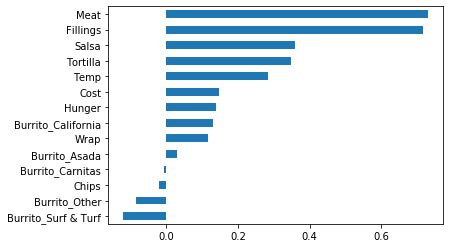

In [28]:
#plot the coefficients
import matplotlib.pyplot as plt
%matplotlib inline
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
coefficients.sort_values().plot.barh();

Models Test Accuracy

In [0]:
X_test = test[features]
X_test_encoded = encoder.transform(X_test)
X_test_imputed = imputer.transform(X_test_encoded)
X_test_scaled = scaler.transform(X_test_imputed)
y_pred = model.predict(X_test_scaled)

In [31]:
print('baseline accuracy score for train set:', ac)
print('baseline accuracy for validation set:',ac)
print('Validation Accuracy', model.score(X_val_scaled, y_val))
print('Test Accuracy', accuracy_score(y_test, y_pred))

baseline accuracy score for train set: 0.5529411764705883
baseline accuracy for validation set: 0.5529411764705883
Validation Accuracy 0.8470588235294118
Test Accuracy 0.7105263157894737
